In [1]:
!pip install kaggle==1.5.12
!mkdir -p ~/.kaggle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73027 sha256=6d6ad14034824d105137a8297c4b506e7c7ced7f310d96ca9eb0b9c14d903017
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [2]:
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 /content/kaggle.json

In [4]:
!kaggle datasets download -d rounakbanik/the-movies-dataset

 86% 197M/228M [00:00<00:00, 263MB/s]
100% 228M/228M [00:00<00:00, 270MB/s]


In [5]:
!unzip the-movies-dataset.zip


Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [6]:
import pandas as pd
import numpy as np

In [114]:
ratings_df = pd.read_csv('/content/ratings.csv')
# drop time stamp
ratings_df.drop('timestamp', axis=1, inplace=True)

print(f"Ratings_df shape : {ratings_df.shape}")
print("\n")
print("-----------------------------------------")
print("\n")

print(f"describe : \n {ratings_df.describe()} ")
print("\n")

print("-----------------------------------------")
print("\n")

print(f"info : \n {ratings_df.info()}")
print("\n")

print("-----------------------------------------")
print("\n")

print(f"Intitally unique user`s : {ratings_df['userId'].nunique()}")
print("\n")

print("-----------------------------------------")
print("\n")

# due to size, we are only going to use first 500 unique users

# ratings_df = ratings_df[ratings_df["userId"].isin(ratings_df["userId"].unique()[:500])]
# print("\n")

# print(f"After filtering, Ratings_df shape : {ratings_df.shape}")
# print("\n")

# print("-----------------------------------------")
# print("\n")

# print(f"After filtering,  unique user`s : {ratings_df['userId'].nunique()}")
# print("\n")

# print("-----------------------------------------")


Ratings_df shape : (26024289, 3)


-----------------------------------------


describe : 
              userId       movieId        rating
count  2.602429e+07  2.602429e+07  2.602429e+07
mean   1.350371e+05  1.584911e+04  3.528090e+00
std    7.817620e+04  3.108526e+04  1.065443e+00
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    6.716400e+04  1.073000e+03  3.000000e+00
50%    1.351630e+05  2.583000e+03  3.500000e+00
75%    2.026930e+05  6.503000e+03  4.000000e+00
max    2.708960e+05  1.762750e+05  5.000000e+00 


-----------------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 595.6 MB
info : 
 None


-----------------------------------------


Intitally unique user`s : 270896


-----------------------------------------




# Creating an Interaction Matrix

## Positive Interaction -> Will be labelled as 1
    ### Hard Positives: rating >= 4
    ### Soft positive: 4>rating>= 3
## Negative Interaction -> will be labelled as 0
    ### Soft Negative: 3>rating>=2
    ### Hard Negative: 2>rating>=1 or less than 1


---


## Ratio of positive : negative for every user : 1:4


---



In [169]:
hardpositve = 4.0
softpositive = 3.0
softnegative = 2.0
hardnegative = 1.

ratings_df["interaction"] = 0
ratings_df.interaction[ratings_df["rating"] >= softpositive] = 1


positive_samples = ratings_df[ratings_df["interaction"] == 1]
negative_samples = ratings_df[ratings_df["interaction"] == 0]
print(f"positive_samples shape : {positive_samples.shape}")
print(f"negative_samples shape : {negative_samples.shape}")

<ipython-input-169-578d9c408abe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df.interaction[ratings_df["rating"] >= softpositive] = 1


positive_samples shape : (21354677, 4)
negative_samples shape : (4669612, 4)


In [118]:
negative_grouped = negative_samples.groupby('userId')
count = 0
for userId, group in negative_grouped:
    if count >= 3:
        break
    print(f"User ID: {userId}")
    print(group)
    print("--------------------")
    count += 1

User ID: 1
    userId  movieId  rating  interaction
0        1      110     1.0            0
20       1    91500     2.5            0
24       1    98809     0.5            0
--------------------
User ID: 2
    userId  movieId  rating  interaction
29       2       32     2.0            0
42       2      786     1.0            0
43       2      788     1.0            0
48       2     1552     2.0            0
--------------------
User ID: 3
    userId  movieId  rating  interaction
50       3      500     2.0            0
--------------------


In [139]:
"""
Some groups have a length of fewer than 4. So we only include groups where len >= 4. only these user
will be added to final balanced dataset .
"""
negative_grouped_with_size4 = negative_grouped.filter(lambda x: len(x) >= 4)
# convert the negative_grouped_with_size4 df to group_by object
negative_grouped = negative_grouped_with_size4.groupby('userId')
count = 0
for userId, group in negative_grouped:
    if count >= 3:
        break
    print(f"User ID: {userId}")
    print(group)
    print("--------------------")
    count += 1


User ID: 2
    userId  movieId  rating  interaction
29       2       32     2.0            0
42       2      786     1.0            0
43       2      788     1.0            0
48       2     1552     2.0            0
--------------------
User ID: 4
     userId  movieId  rating  interaction
64        4     1210     2.0            0
76        4     2338     2.0            0
84        4     2694     1.0            0
86        4     2710     2.0            0
95        4     3004     1.0            0
103       4     3409     2.0            0
106       4     3623     2.0            0
111       4     3908     2.0            0
--------------------
User ID: 7
     userId  movieId  rating  interaction
157       7     3948     1.5            0
159       7     4306     2.5            0
163       7     5810     2.0            0
166       7     6934     2.0            0
170       7     8961     2.5            0
171       7    30793     2.5            0
175       7    40815     2.5            0
176   

In [149]:
# number of unique user_id in neagtive grouped. we will only use first 5000 unique users.
len(negative_grouped['userId'].unique())

141140

In [163]:
# unique instance of positive interactin
unique_positive_samples = positive_samples.drop_duplicates(subset=['userId'])
print(f"unique_positive_samples shape : {unique_positive_samples.shape}")
unique_positive_samples.head()

unique_positive_samples shape : (269316, 4)


,userId,movieId,rating,interaction
1,1,147,4.5,1
27,2,5,3.0,1
49,3,480,3.0,1
59,4,223,4.0,1
121,5,7,3.0,1


In [164]:
balanced_list = []

for user_id in list(negative_grouped.groups.keys())[:5000]:
      # Append the positive samples for the user
    balanced_list.append(unique_positive_samples[unique_positive_samples['userId'] == user_id])
    # Append the negative samples for the user
    negative_samples_for_user = negative_grouped.get_group(user_id)
    # Sample 4 negative samples for the user
    balanced_list.append(negative_samples_for_user.sample(4, replace=False))

# Concatenate all the samples into a single DataFrame
balanced_df = pd.concat(balanced_list).reset_index(drop=True)

print(balanced_df)

       userId  movieId  rating  interaction
0           2        5     3.0            1
1           2       32     2.0            0
2           2     1552     2.0            0
3           2      788     1.0            0
4           2      786     1.0            0
...       ...      ...     ...          ...
24984    9715        1     4.0            1
24985    9715    38038     2.5            0
24986    9715    30793     2.0            0
24987    9715      364     2.0            0
24988    9715    96079     0.5            0

[24989 rows x 4 columns]


In [170]:
positive_count = len(balanced_df[balanced_df["interaction"] == 1])
negative_count = len(balanced_df[balanced_df["interaction"] == 0])

print(f"Number of positive samples: {positive_count}")
print(f"Number of negative samples: {negative_count}")

ratio = positive_count / negative_count
print(f"Ratio of positive to negative samples: {ratio}")

Number of positive samples: 4989
Number of negative samples: 20000
Ratio of positive to negative samples: 0.24945


In [167]:
import csv
balanced_df.to_csv('balanced_ratings_1:4.csv', index=False)

In [170]:
class nvf:
  def __init__(self,df):
    self.df = df
    self.df.drop("ratings", inplace = True)
    self.embedding_size = 50
    self.user_input = Input(shape=(1,), name='user_input')
    self.movie_input = Input(shape=(1,), name='movie_input')

  def gmf(self):
    user_embedding_gmf = Embedding(input_dim=len(users), output_dim=embedding_size, name='user_embedding_gmf')(user_input)
    movie_embedding_gmf = Embedding(input_dim=len(movies), output_dim=embedding_size, name='movie_embedding_gmf')(movie_input)
    gmf_vector = Flatten()(user_embedding_gmf) * Flatten()(movie_embedding_gmf)
    gmf_output = Dense(1, activation='sigmoid', name='gmf_output')(gmf_vector)
    gmf_model = Model(inputs=[user_input, movie_input], outputs=gmf_output)


Generalized Matrix Factorization (GMF)
Multi-Layer Perceptron (MLP)

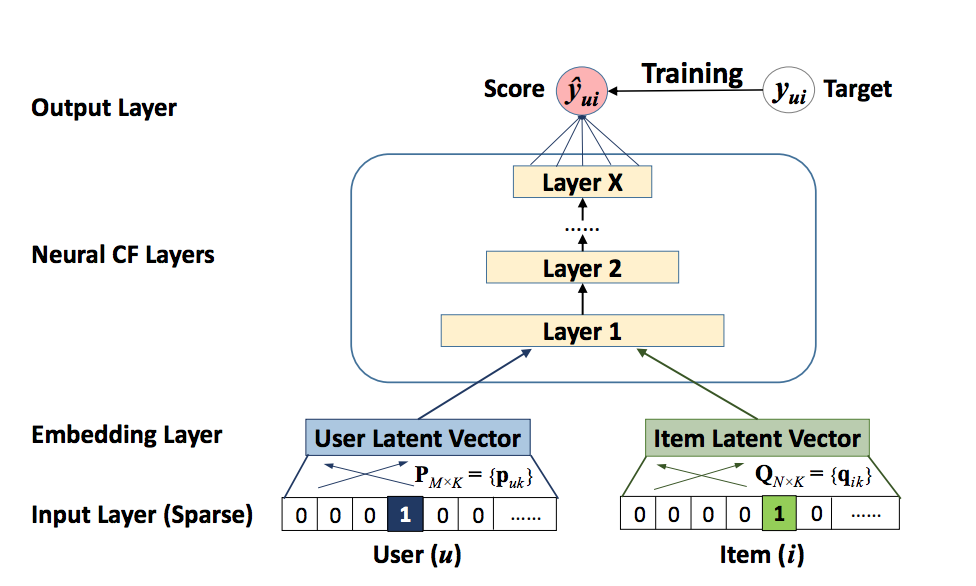

In [3]:

balanced_df = pd.read_csv("/content/balanced_ratings_1_4.csv")
balanced_df.head()


,userId,movieId,rating,interaction
0,2,5,3.0,1
1,2,32,2.0,0
2,2,1552,2.0,0
3,2,788,1.0,0
4,2,786,1.0,0


In [11]:
X = balanced_df.iloc[:,:2]
y = balanced_df.interaction
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
X_train.iloc[:,0]

,userId
18841,7283
13154,5043
2712,1036
20011,7734
11013,4220
...,...
21575,8363
5390,2056
860,331
15795,6031


# First try at building model
Result - model overfitting.

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, concatenate, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np


def build_model(num_users, num_items , embedding_dim):
  user_input = Input(shape=(1,))
  item_input = Input(shape=(1,))
  user_embedding = Embedding(num_users, embedding_dim)(user_input)
  # user_embedding = Flatten()(user_embedding)
  item_embedding = Embedding(num_items, embedding_dim)(item_input)
  # item_embedding = Flatten()(item_embedding)
  gmf_vector = Flatten()(user_embedding) * Flatten()(item_embedding)

  ## MLP Layer
  user_embedding = Embedding(num_users, embedding_dim)(user_input)
  # user_embedding = Flatten()(user_embedding)
  item_embedding = Embedding(num_items,embedding_dim)(item_input)
  # item_embedding = Flatten()(item_embedding)
  mlp_vector = concatenate([Flatten()(user_embedding), Flatten()(item_embedding)])

  mlp_vector = Dense(64, activation='relu')(mlp_vector)
  mlp_vector = Dense(32, activation='relu')(mlp_vector)

  ncf_vector = concatenate([gmf_vector, mlp_vector])
  output = Dense(1, activation = "sigmoid")(mlp_vector)
  ncf_model = Model(inputs = [user_input, item_input], outputs = output)
  ncf_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
  ncf_model.summary()
  return ncf_model
# def train_model(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=64):
#   model.fit([X_train.iloc[:, 0], X_train.iloc[:, 1]], y_train,
#             epochs=epochs, batch_size=batch_size,
#             validation_data=([X_test.iloc[:, 0], X_test.iloc[:, 1]], y_test))


num_users = balanced_df.userId.max()+1
num_items = balanced_df.movieId.max()+1
embedding_dim = 50
model = build_model(num_users, num_items, embedding_dim)
model.fit([X_train.iloc[:, 0], X_train.iloc[:, 1]], y_train, epochs=10, batch_size=64, validation_data=([X_test.iloc[:, 0], X_test.iloc[:, 1]], y_test))
loss, accuracy = model.evaluate([X_test.iloc[:, 0], X_test.iloc[:, 1]], y_test)
print(f'Test Accuracy: {accuracy:.4f}')



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_22 (Embedding)  │ (None, 1, 50)          │        485,800 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_23 (Embedding)  │ (None, 1, 50)          │      8,773,800 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_22 (Flatten)      │ (None, 50)             │              0 │ embedding_22[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_23 (Flatten)      │ (None, 50)             │              0 │ embedding_23[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 100)            │              0 │ flatten_22[0][0],      │
│ (Concatenate)             │                        │                │ flatten_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 64)             │          6,464 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 32)             │          2,080 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 1)              │             33 │ dense_16[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,268,177 (35.36 MB)

 Trainable params: 9,268,177 (35.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 176ms/step - accuracy: 0.8592 - loss: 0.4194 - val_accuracy: 0.9258 - val_loss: 0.2254
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 181ms/step - accuracy: 0.9239 - loss: 0.1867 - val_accuracy: 0.9186 - val_loss: 0.2495
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 178ms/step - accuracy: 0.9460 - loss: 0.1199 - val_accuracy: 0.9058 - val_loss: 0.3428
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 178ms/step - accuracy: 0.9674 - loss: 0.0704 - val_accuracy: 0.8872 - val_loss: 0.4766
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.9784 - loss: 0.0512 - val_accuracy: 0.8772 - val_loss: 0.5627
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 84s 175ms/step - accuracy: 0.9839 - loss: 0.0406 - val_accuracy: 0.8737 - val_loss: 0.6523
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step - accuracy: 0.9861 - loss: 0.0327 - val_accuracy: 0.8754 - val_loss: 0.7579
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - accuracy: 0.9910 - loss: 0

# 2nd try
implemented

1.   droup out layers



In [22]:
from keras.layers import Input, Embedding, Flatten, concatenate, Dense, Dropout
from keras.models import Model

def build_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    # GMF Part
    user_embedding_gmf = Embedding(num_users, embedding_dim)(user_input)
    item_embedding_gmf = Embedding(num_items, embedding_dim)(item_input)
    gmf_vector = Flatten()(user_embedding_gmf) * Flatten()(item_embedding_gmf)

    # MLP Part
    user_embedding_mlp = Embedding(num_users, embedding_dim)(user_input)
    item_embedding_mlp = Embedding(num_items, embedding_dim)(item_input)
    mlp_vector = concatenate([Flatten()(user_embedding_mlp), Flatten()(item_embedding_mlp)])


    mlp_vector = Dense(64, activation='relu',kernel_regularizer=l2(0.001))(mlp_vector)
    mlp_vector = Dropout(0.3)(mlp_vector)  # Dropout layer added here
    mlp_vector = Dense(32, activation='relu',kernel_regularizer=l2(0.001))(mlp_vector)
    mlp_vector = Dropout(0.3)(mlp_vector)  # Dropout layer added here

    # Concatenate GMF and MLP parts
    ncf_vector = concatenate([gmf_vector, mlp_vector])

    # Final output layer
    output = Dense(1, activation="sigmoid")(ncf_vector)

    # Build and compile the model
    ncf_model = Model(inputs=[user_input, item_input], outputs=output)
    ncf_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    ncf_model.summary()

    return ncf_model

# Example usage
num_users = balanced_df.userId.max() + 1
num_items = balanced_df.movieId.max() + 1
embedding_dim = 50
model = build_model(num_users, num_items, embedding_dim)
model.fit([X_train.iloc[:, 0], X_train.iloc[:, 1]], y_train, epochs=10, batch_size=64, validation_data=([X_test.iloc[:, 0], X_test.iloc[:, 1]], y_test))
loss, accuracy = model.evaluate([X_test.iloc[:, 0], X_test.iloc[:, 1]], y_test)
print(f'Test Accuracy: {accuracy:.4f}')


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_13            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_26 (Embedding)  │ (None, 1, 50)          │        485,800 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_27 (Embedding)  │ (None, 1, 50)          │      8,773,800 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_26 (Flatten)      │ (None, 50)             │              0 │ embedding_26[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_27 (Flatten)      │ (None, 50)             │              0 │ embedding_27[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 100)            │              0 │ flatten_26[0][0],      │
│ (Concatenate)             │                        │                │ flatten_27[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 64)             │          6,464 │ concatenate_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_24 (Embedding)  │ (None, 1, 50)          │        485,800 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_25 (Embedding)  │ (None, 1, 50)          │      8,773,800 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_24 (Flatten)      │ (None, 50)             │              0 │ embedding_24[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_25 (Flatten)      │ (None, 50)             │              0 │ embedding_25[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 32)             │          2,080 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_6 (Multiply)     │ (None, 50)             │              0 │ flatten_24[0][0],      │
│                           │                        │                │ flatten_25[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_13            │ (None, 82)             │              0 │ multiply_6[0][0],      │
│ (Concatenate)             │                        │                │ dropout_1[0][0]        │
├──────────────────────

 Total params: 18,527,827 (70.68 MB)

 Trainable params: 18,527,827 (70.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 300ms/step - accuracy: 0.8316 - loss: 0.4689 - val_accuracy: 0.9226 - val_loss: 0.2288
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 295ms/step - accuracy: 0.9276 - loss: 0.1904 - val_accuracy: 0.9174 - val_loss: 0.2449
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 287ms/step - accuracy: 0.9436 - loss: 0.1386 - val_accuracy: 0.9042 - val_loss: 0.3187
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 278ms/step - accuracy: 0.9778 - loss: 0.0714 - val_accuracy: 0.8964 - val_loss: 0.4309
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 290ms/step - accuracy: 0.9961 - loss: 0.0327 - val_accuracy: 0.8904 - val_loss: 0.5478
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 308ms/step - accuracy: 0.9991 - loss: 0.0149 - val_accuracy: 0.8854 - val_loss: 0.6252
Epoch 7/10
110/313 ━━━━━━━━━━━━━━━━━━━━ 56s 280ms/step - accuracy: 0.9996 - loss: 0.0070

KeyboardInterrupt: 

# 3rd Try - highest till now.
implemented:
1.  l2 regularization
2.  droupout layer
3. early stopping

Results: Better results than before

Saving this model for furthur use.




In [24]:
from keras.layers import Input, Embedding, Flatten, concatenate, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.regularizers import l2


def build_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    # GMF Part
    user_embedding_gmf = Embedding(num_users, embedding_dim)(user_input)
    item_embedding_gmf = Embedding(num_items, embedding_dim)(item_input)
    gmf_vector = Flatten()(user_embedding_gmf) * Flatten()(item_embedding_gmf)

    # MLP Part
    user_embedding_mlp = Embedding(num_users, embedding_dim)(user_input)
    item_embedding_mlp = Embedding(num_items, embedding_dim)(item_input)
    mlp_vector = concatenate([Flatten()(user_embedding_mlp), Flatten()(item_embedding_mlp)])


    mlp_vector = Dense(64, activation='relu',kernel_regularizer=l2(0.001))(mlp_vector)
    mlp_vector = Dropout(0.3)(mlp_vector)  # Dropout layer added here
    mlp_vector = Dense(32, activation='relu',kernel_regularizer=l2(0.001))(mlp_vector)
    mlp_vector = Dropout(0.3)(mlp_vector)  # Dropout layer added here

    # Concatenate GMF and MLP parts
    ncf_vector = concatenate([gmf_vector, mlp_vector])

    # Final output layer
    output = Dense(1, activation="sigmoid")(ncf_vector)

    # Build and compile the model
    ncf_model = Model(inputs=[user_input, item_input], outputs=output)
    ncf_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    ncf_model.summary()

    return ncf_model

# Example usage
num_users = balanced_df.userId.max() + 1
num_items = balanced_df.movieId.max() + 1
embedding_dim = 50
model = build_model(num_users, num_items, embedding_dim)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit([X_train.iloc[:, 0], X_train.iloc[:, 1]], y_train, epochs=10, batch_size=64,
          validation_data=([X_test.iloc[:, 0],X_test.iloc[:, 1]], y_test),callbacks=[early_stopping])
loss, accuracy = model.evaluate([X_test.iloc[:, 0], X_test.iloc[:, 1]], y_test)
print(f'Test Accuracy: {accuracy:.4f}')


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_17            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_34 (Embedding)  │ (None, 1, 50)          │        485,800 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_35 (Embedding)  │ (None, 1, 50)          │      8,773,800 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_34 (Flatten)      │ (None, 50)             │              0 │ embedding_34[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_35 (Flatten)      │ (None, 50)             │              0 │ embedding_35[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_15            │ (None, 100)            │              0 │ flatten_34[0][0],      │
│ (Concatenate)             │                        │                │ flatten_35[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 64)             │          6,464 │ concatenate_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_32 (Embedding)  │ (None, 1, 50)          │        485,800 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_33 (Embedding)  │ (None, 1, 50)          │      8,773,800 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_32 (Flatten)      │ (None, 50)             │              0 │ embedding_32[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_33 (Flatten)      │ (None, 50)             │              0 │ embedding_33[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 32)             │          2,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_8 (Multiply)     │ (None, 50)             │              0 │ flatten_32[0][0],      │
│                           │                        │                │ flatten_33[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_16            │ (None, 82)             │              0 │ multiply_8[0][0],      │
│ (Concatenate)             │                        │                │ dropout_3[0][0]        │
├──────────────────────

 Total params: 18,527,827 (70.68 MB)

 Trainable params: 18,527,827 (70.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 89s 275ms/step - accuracy: 0.8353 - loss: 0.5410 - val_accuracy: 0.9248 - val_loss: 0.2548
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 152s 307ms/step - accuracy: 0.9239 - loss: 0.2249 - val_accuracy: 0.9206 - val_loss: 0.2503
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 139s 299ms/step - accuracy: 0.9385 - loss: 0.1757 - val_accuracy: 0.9062 - val_loss: 0.2961
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 150s 326ms/step - accuracy: 0.9668 - loss: 0.1096 - val_accuracy: 0.8920 - val_loss: 0.3479
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 328ms/step - accuracy: 0.9930 - loss: 0.0596 - val_accuracy: 0.8872 - val_loss: 0.3823
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9176 - loss: 0.2583
Test Accuracy: 0.9206


# 4th try
implemented:


1.   increased no of layers. 2 -> 3 layers. (64, 32, 16)
2.   plus whatever in last model



In [25]:
from keras.layers import Input, Embedding, Flatten, concatenate, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.regularizers import l2


def build_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    # GMF Part
    user_embedding_gmf = Embedding(num_users, embedding_dim)(user_input)
    item_embedding_gmf = Embedding(num_items, embedding_dim)(item_input)
    gmf_vector = Flatten()(user_embedding_gmf) * Flatten()(item_embedding_gmf)

    # MLP Part
    user_embedding_mlp = Embedding(num_users, embedding_dim)(user_input)
    item_embedding_mlp = Embedding(num_items, embedding_dim)(item_input)
    mlp_vector = concatenate([Flatten()(user_embedding_mlp), Flatten()(item_embedding_mlp)])


    mlp_vector = Dense(64, activation='relu',kernel_regularizer=l2(0.001))(mlp_vector)
    mlp_vector = Dropout(0.3)(mlp_vector)  # Dropout layer added here
    mlp_vector = Dense(32, activation='relu',kernel_regularizer=l2(0.001))(mlp_vector)
    mlp_vector = Dropout(0.3)(mlp_vector)  # Dropout layer added here
    mlp_vector = Dense(16, activation='relu',kernel_regularizer=l2(0.001))(mlp_vector)
    mlp_vector = Dropout(0.3)(mlp_vector)  # Dropout layer added here

    # Concatenate GMF and MLP parts
    ncf_vector = concatenate([gmf_vector, mlp_vector])

    # Final output layer
    output = Dense(1, activation="sigmoid")(ncf_vector)

    # Build and compile the model
    ncf_model = Model(inputs=[user_input, item_input], outputs=output)
    ncf_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    ncf_model.summary()

    return ncf_model

# Example usage
num_users = balanced_df.userId.max() + 1
num_items = balanced_df.movieId.max() + 1
embedding_dim = 50
model = build_model(num_users, num_items, embedding_dim)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit([X_train.iloc[:, 0], X_train.iloc[:, 1]], y_train, epochs=10, batch_size=64,
          validation_data=([X_test.iloc[:, 0],X_test.iloc[:, 1]], y_test),callbacks=[early_stopping])
loss, accuracy = model.evaluate([X_test.iloc[:, 0], X_test.iloc[:, 1]], y_test)
print(f'Test Accuracy: {accuracy:.4f}')


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_19            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_38 (Embedding)  │ (None, 1, 50)          │        485,800 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_39 (Embedding)  │ (None, 1, 50)          │      8,773,800 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_38 (Flatten)      │ (None, 50)             │              0 │ embedding_38[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_39 (Flatten)      │ (None, 50)             │              0 │ embedding_39[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_17            │ (None, 100)            │              0 │ flatten_38[0][0],      │
│ (Concatenate)             │                        │                │ flatten_39[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 64)             │          6,464 │ concatenate_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 32)             │          2,080 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_36 (Embedding)  │ (None, 1, 50)          │        485,800 │ input_layer_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_37 (Embedding)  │ (None, 1, 50)          │      8,773,800 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 32)             │              0 │ dense_25[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_36 (Flatten)      │ (None, 50)             │              0 │ embedding_36[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_37 (Flatten)      │ (None, 50)             │              0 │ embedding_37[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 16)             │            528 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_9 (Multiply)     │ (None, 50)             │              0 │ flatten_36[0][0],      │
│                           │                        │                │ flatten_37[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)  

 Total params: 18,528,339 (70.68 MB)

 Trainable params: 18,528,339 (70.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 274ms/step - accuracy: 0.8065 - loss: 0.5878 - val_accuracy: 0.9234 - val_loss: 0.2613
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 86s 273ms/step - accuracy: 0.9252 - loss: 0.2409 - val_accuracy: 0.9174 - val_loss: 0.2571
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 277ms/step - accuracy: 0.9372 - loss: 0.1905 - val_accuracy: 0.8974 - val_loss: 0.2974
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 276ms/step - accuracy: 0.9667 - loss: 0.1223 - val_accuracy: 0.8854 - val_loss: 0.3720
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 144s 282ms/step - accuracy: 0.9910 - loss: 0.0667 - val_accuracy: 0.8834 - val_loss: 0.4016
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9170 - loss: 0.2644
Test Accuracy: 0.9174


# 5th try - new highest. slightly higher than 3
implementing:


1.   decreasing model complexity
2.   rest same from last model



In [27]:
from keras.layers import Input, Embedding, Flatten, concatenate, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.regularizers import l2


def build_model(num_users, num_items, embedding_dim):
    user_input = Input(shape=(1,))
    item_input = Input(shape=(1,))

    # GMF Part
    user_embedding_gmf = Embedding(num_users, embedding_dim)(user_input)
    item_embedding_gmf = Embedding(num_items, embedding_dim)(item_input)
    gmf_vector = Flatten()(user_embedding_gmf) * Flatten()(item_embedding_gmf)

    # MLP Part
    user_embedding_mlp = Embedding(num_users, embedding_dim)(user_input)
    item_embedding_mlp = Embedding(num_items, embedding_dim)(item_input)
    mlp_vector = concatenate([Flatten()(user_embedding_mlp), Flatten()(item_embedding_mlp)])


    # mlp_vector = Dense(64, activation='relu',kernel_regularizer=l2(0.001))(mlp_vector)
    # mlp_vector = Dropout(0.3)(mlp_vector)  # Dropout layer added here
    mlp_vector = Dense(32, activation='relu',kernel_regularizer=l2(0.001))(mlp_vector)
    mlp_vector = Dropout(0.3)(mlp_vector)  # Dropout layer added here
    mlp_vector = Dense(16, activation='relu',kernel_regularizer=l2(0.001))(mlp_vector)
    mlp_vector = Dropout(0.3)(mlp_vector)  # Dropout layer added here

    # Concatenate GMF and MLP parts
    ncf_vector = concatenate([gmf_vector, mlp_vector])

    # Final output layer
    output = Dense(1, activation="sigmoid")(ncf_vector)

    # Build and compile the model
    ncf_model = Model(inputs=[user_input, item_input], outputs=output)
    ncf_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    ncf_model.summary()

    return ncf_model

# Example usage
num_users = balanced_df.userId.max() + 1
num_items = balanced_df.movieId.max() + 1
embedding_dim = 50
model = build_model(num_users, num_items, embedding_dim)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit([X_train.iloc[:, 0], X_train.iloc[:, 1]], y_train, epochs=10, batch_size=64,
          validation_data=([X_test.iloc[:, 0],X_test.iloc[:, 1]], y_test),callbacks=[early_stopping])
loss, accuracy = model.evaluate([X_test.iloc[:, 0], X_test.iloc[:, 1]], y_test)
print(f'Test Accuracy: {accuracy:.4f}')


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_23            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_46 (Embedding)  │ (None, 1, 50)          │        485,800 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_47 (Embedding)  │ (None, 1, 50)          │      8,773,800 │ input_layer_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_46 (Flatten)      │ (None, 50)             │              0 │ embedding_46[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_47 (Flatten)      │ (None, 50)             │              0 │ embedding_47[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_21            │ (None, 100)            │              0 │ flatten_46[0][0],      │
│ (Concatenate)             │                        │                │ flatten_47[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 32)             │          3,232 │ concatenate_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_44 (Embedding)  │ (None, 1, 50)          │        485,800 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_45 (Embedding)  │ (None, 1, 50)          │      8,773,800 │ input_layer_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 32)             │              0 │ dense_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_44 (Flatten)      │ (None, 50)             │              0 │ embedding_44[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_45 (Flatten)      │ (None, 50)             │              0 │ embedding_45[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 16)             │            528 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_11 (Multiply)    │ (None, 50)             │              0 │ flatten_44[0][0],      │
│                           │                        │                │ flatten_45[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 16)             │              0 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_22            │ (None, 66)             │              0 │ multiply_11[0][0],     │
│ (Concatenate)             │                        │                │ dropout_10[0][0]       │
├──────────────────────

 Total params: 18,523,027 (70.66 MB)

 Trainable params: 18,523,027 (70.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


Exception ignored in: <function _xla_gc_callback at 0x7c141af7c430>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


313/313 ━━━━━━━━━━━━━━━━━━━━ 122s 311ms/step - accuracy: 0.8082 - loss: 0.5781 - val_accuracy: 0.9242 - val_loss: 0.2544
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 133s 282ms/step - accuracy: 0.9267 - loss: 0.2283 - val_accuracy: 0.9226 - val_loss: 0.2467
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 288ms/step - accuracy: 0.9355 - loss: 0.1927 - val_accuracy: 0.9074 - val_loss: 0.2847
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 140s 281ms/step - accuracy: 0.9692 - loss: 0.1194 - val_accuracy: 0.8892 - val_loss: 0.3401
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 169s 366ms/step - accuracy: 0.9924 - loss: 0.0672 - val_accuracy: 0.8932 - val_loss: 0.3660
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9207 - loss: 0.2539
Test Accuracy: 0.9226


In [28]:
model.save("ncf_model.h5")